In [24]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
xlsx_path = "/content/1730285881-Airbnb_Open_Data.xlsx"
assert os.path.exists(xlsx_path)

# The sheet name appears to be 'in' based on your file metadata
df = pd.read_excel(xlsx_path, sheet_name="in", engine="openpyxl")

print("Loaded rows:", len(df))
print("Loaded columns:", len(df.columns))
print(df.head())

Loaded rows: 102599
Loaded columns: 26
        id                                              NAME      host id host_identity_verified host name neighbourhood group neighbourhood       lat  \
0  1001254                Clean & quiet apt home by the park  80014485718            unconfirmed  Madaline            Brooklyn    Kensington  40.64749   
1  1002102                             Skylit Midtown Castle  52335172823               verified     Jenna           Manhattan       Midtown  40.75362   
2  1002403               THE VILLAGE OF HARLEM....NEW YORK !  78829239556                    NaN     Elise           Manhattan        Harlem  40.80902   
3  1002755                                               NaN  85098326012            unconfirmed     Garry            Brooklyn  Clinton Hill  40.68514   
4  1003689  Entire Apt: Spacious Studio/Loft by central park  92037596077               verified    Lyndon           Manhattan   East Harlem  40.79851   

       long        country country c

In [26]:
# Data wrangling: rename columns, parse dates, coerce numerics, engineer helpful columns

# Standardize column names (lowercase, underscores)
df.columns = (
    df.columns.str.strip()
              .str.lower()
              .str.replace(" ", "_")
              .str.replace("/", "_")
)

# Known date and numeric fields
date_cols = ["last_review"]
for c in date_cols:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce", unit="ms") if np.issubdtype(df[c].dtype, np.number) else pd.to_datetime(df[c], errors="coerce")

num_cols = [
    "lat","long","price","service_fee","minimum_nights","number_of_reviews",
    "reviews_per_month","review_rate_number","calculated_host_listings_count","availability_365",
    "construction_year","host_id","id"
]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Normalize some categoricals if present
cat_map = {
    "host_identity_verified": {"verified":"verified","unconfirmed":"unconfirmed",True:"verified",False:"unconfirmed"},
    "instant_bookable": {True:"yes", False:"no", "t":"yes", "f":"no"},
}
for c, mapping in cat_map.items():
    if c in df.columns:
        df[c] = df[c].map(mapping).fillna(df[c].astype(str).str.lower())

# Room type normalization
if "room_type" in df.columns:
    df["room_type"] = df["room_type"].astype(str).str.strip()

# Neighborhoods
for c in ["neighbourhood_group","neighbourhood","country","country_code","cancellation_policy"]:
    if c in df.columns:
        df[c] = df[c].astype(str).str.strip()

# Price sanity filter (optional, keeps robust analysis)
if "price" in df.columns:
    df = df[df["price"].between(10, 2000)]

# Create useful features
if "last_review" in df.columns:
    df["last_review_year"] = df["last_review"].dt.year

# nights per price proxy (avoid division by zero)
if set(["price","minimum_nights"]).issubset(df.columns):
    df["price_per_night"] = np.where(df["minimum_nights"] > 0, df["price"] / df["minimum_nights"], np.nan)

print("Cleaned and engineered")
print(df.head())

Cleaned and engineered
        id                                              name      host_id host_identity_verified host_name neighbourhood_group neighbourhood       lat  \
0  1001254                Clean & quiet apt home by the park  80014485718            unconfirmed  Madaline            Brooklyn    Kensington  40.64749   
1  1002102                             Skylit Midtown Castle  52335172823               verified     Jenna           Manhattan       Midtown  40.75362   
2  1002403               THE VILLAGE OF HARLEM....NEW YORK !  78829239556                    nan     Elise           Manhattan        Harlem  40.80902   
3  1002755                                               NaN  85098326012            unconfirmed     Garry            Brooklyn  Clinton Hill  40.68514   
4  1003689  Entire Apt: Spacious Studio/Loft by central park  92037596077               verified    Lyndon           Manhattan   East Harlem  40.79851   

       long        country country_code instant_book

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 102352 entries, 0 to 102598
Data columns (total 28 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   id                              102352 non-null  int64         
 1   name                            102085 non-null  object        
 2   host_id                         102352 non-null  int64         
 3   host_identity_verified          102352 non-null  object        
 4   host_name                       101949 non-null  object        
 5   neighbourhood_group             102352 non-null  object        
 6   neighbourhood                   102352 non-null  object        
 7   lat                             102344 non-null  float64       
 8   long                            102344 non-null  float64       
 9   country                         102352 non-null  object        
 10  country_code                    102352 non-null  object      

In [12]:
# Missingness profile and basic summary
na_summary = df.isna().mean().sort_values(ascending=False).head(15) * 100
print(na_summary)

basic_desc = df[["price","service_fee","minimum_nights","number_of_reviews","reviews_per_month","availability_365"]].describe(percentiles=[0.25,0.5,0.75]).T
print(basic_desc)
print("Profiled missingness and stats")

license                           99.998046
house_rules                       53.443020
last_review_year                  15.502384
last_review                       15.502384
reviews_per_month                 15.487729
availability_365                   0.437705
price_per_night                    0.412303
minimum_nights                     0.399601
host_name                          0.393739
review_rate_number                 0.318509
calculated_host_listings_count     0.311670
name                               0.260864
service_fee                        0.233508
construction_year                  0.205174
number_of_reviews                  0.178795
dtype: float64
                      count        mean         std      min     25%     50%     75%     max
price              102352.0  625.293536  331.671614    50.00  340.00  624.00  913.00  1200.0
service_fee        102113.0  125.038399   66.333513    10.00   68.00  125.00  183.00   240.0
minimum_nights     101943.0    8.125619   30.5

**(1)What are the different property types in the dataset?**

In [28]:
# 1️⃣ Different Property Types (Room Types) in the Dataset

if "room_type" in df.columns:
    room_counts = df["room_type"].value_counts().reset_index()
    room_counts.columns = ["room_type", "count"]

    print("Property Types (Room Types) and Counts:\n")
    print(room_counts)

    fig = px.bar(
        room_counts,
        x="room_type",
        y="count",
        title="Distribution of Property Types (Room Types)",
        color="room_type",
        text="count"
    )
    fig.update_traces(textposition="outside")
    fig.show()
else:
    print("Column 'room_type' not found in dataset.")


Property Types (Room Types) and Counts:

         room_type  count
0  Entire home/apt  53568
1     Private room  46450
2      Shared room   2218
3       Hotel room    116


**(2)Which neighborhood group has the highest number of listings?**

In [29]:
# 2️⃣ Neighborhood Group with Highest Number of Listings

if "neighbourhood_group" in df.columns:
    group_counts = df["neighbourhood_group"].value_counts().reset_index()
    group_counts.columns = ["neighbourhood_group", "count"]

    print("Listings Count by Neighborhood Group:\n")
    print(group_counts)

    fig = px.bar(
        group_counts,
        x="neighbourhood_group",
        y="count",
        title="Number of Listings by Neighborhood Group",
        color="neighbourhood_group",
        text="count"
    )
    fig.update_traces(textposition="outside")
    fig.show()
else:
    print("Column 'neighbourhood_group' not found in dataset.")


Listings Count by Neighborhood Group:

  neighbourhood_group  count
0           Manhattan  43682
1            Brooklyn  41749
2              Queens  13234
3               Bronx   2705
4       Staten Island    952
5                 nan     28
6            manhatan      1
7             brookln      1


**(3) Which neighborhood groups have the highest average prices?**

In [30]:
# 3️⃣ Neighborhood Groups with Highest Average (Median) Prices

if set(["neighbourhood_group", "room_type", "price"]).issubset(df.columns):
    price_summary = (
        df.groupby(["neighbourhood_group", "room_type"], as_index=False)["price"]
          .median()
          .sort_values(["neighbourhood_group", "price"], ascending=[True, False])
    )

    print("Median Prices by Neighborhood Group and Room Type:\n")
    print(price_summary.head(10))

    fig = px.bar(
        price_summary,
        x="neighbourhood_group",
        y="price",
        color="room_type",
        barmode="group",
        title="Median Price by Neighborhood Group and Room Type",
        labels={"neighbourhood_group": "Neighborhood Group", "price": "Median Price (USD)"}
    )
    fig.show()
else:
    print("Required columns not found in dataset.")


Median Prices by Neighborhood Group and Room Type:

   neighbourhood_group        room_type  price
1                Bronx     Private room  652.0
0                Bronx  Entire home/apt  613.0
2                Bronx      Shared room  608.0
4             Brooklyn       Hotel room  836.0
6             Brooklyn      Shared room  662.0
3             Brooklyn  Entire home/apt  626.0
5             Brooklyn     Private room  624.0
8            Manhattan       Hotel room  644.5
10           Manhattan      Shared room  640.5
7            Manhattan  Entire home/apt  622.0


**(4) Is there a relationship between construction year and price? **

Correlation between construction year and price: -0.004


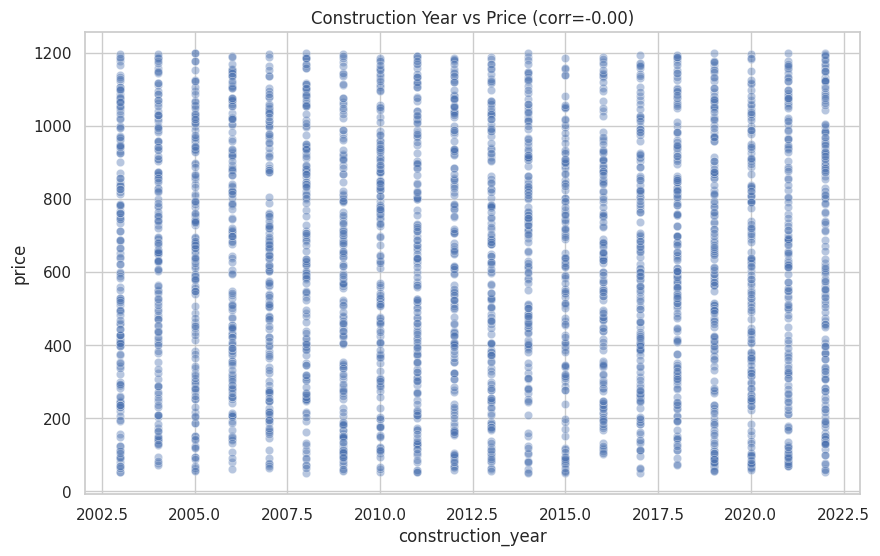

In [18]:
# 4️⃣ Relationship between construction year and price
if "construction_year" in df.columns and "price" in df.columns:
    df_valid = df.dropna(subset=["construction_year", "price"])
    corr_value = df_valid["construction_year"].corr(df_valid["price"])
    print(f"Correlation between construction year and price: {corr_value:.3f}")

    sns.scatterplot(data=df_valid.sample(min(3000, len(df_valid)), random_state=42),
                    x="construction_year", y="price", alpha=0.4)
    plt.title(f"Construction Year vs Price (corr={corr_value:.2f})")
    plt.show()
else:
    print("No 'construction_year' column found in dataset.")


**(5) Who are the top 10 hosts by calculated host listing count?**

In [19]:
# 5️⃣ Top 10 hosts by calculated host listing count
if set(["host_name","calculated_host_listings_count"]).issubset(df.columns):
    top_hosts = (df.groupby("host_name")["calculated_host_listings_count"]
                   .max()
                   .sort_values(ascending=False)
                   .head(10)
                   .reset_index())
    print("Top 10 Hosts by Listing Count:\n", top_hosts)
    fig = px.bar(top_hosts, x="host_name", y="calculated_host_listings_count",
                 title="Top 10 Hosts by Calculated Listing Count",
                 labels={"host_name":"Host Name", "calculated_host_listings_count":"Listing Count"})
    fig.show()
else:
    print("Required columns not found.")


Top 10 Hosts by Listing Count:
       host_name  calculated_host_listings_count
0    Blueground                           332.0
1  Sonder (NYC)                           327.0
2        Eugene                           218.0
3         Karen                           208.0
4      Jeniffer                           186.0
5          Soya                           171.0
6           Kaz                           161.0
7        Hiroki                           152.0
8        Momoyo                           126.0
9         Shogo                           125.0


**(6) Are hosts with verified identities more likely to receive positive reviews?**

In [20]:
# 6️⃣ Hosts with verified identities vs average review rating

if set(["host_identity_verified", "review_rate_number"]).issubset(df.columns):
    verified_stats = df.groupby("host_identity_verified")["review_rate_number"].mean().reset_index()
    print("Average Review Rating by Host Identity Verification:\n", verified_stats)

    fig = px.bar(
        verified_stats,
        x="host_identity_verified",
        y="review_rate_number",
        title="Average Review Rating by Host Verification Status",
        labels={
            "host_identity_verified": "Host Verified?",
            "review_rate_number": "Average Review Rating"
        },
        color="host_identity_verified"
    )
    fig.show()
else:
    print("Required columns not found.")


Average Review Rating by Host Identity Verification:
   host_identity_verified  review_rate_number
0                    nan            3.239852
1            unconfirmed            3.271565
2               verified            3.287220


**(7) Is there a correlation between price and service fee?**

Correlation between price and service fee: 1.000


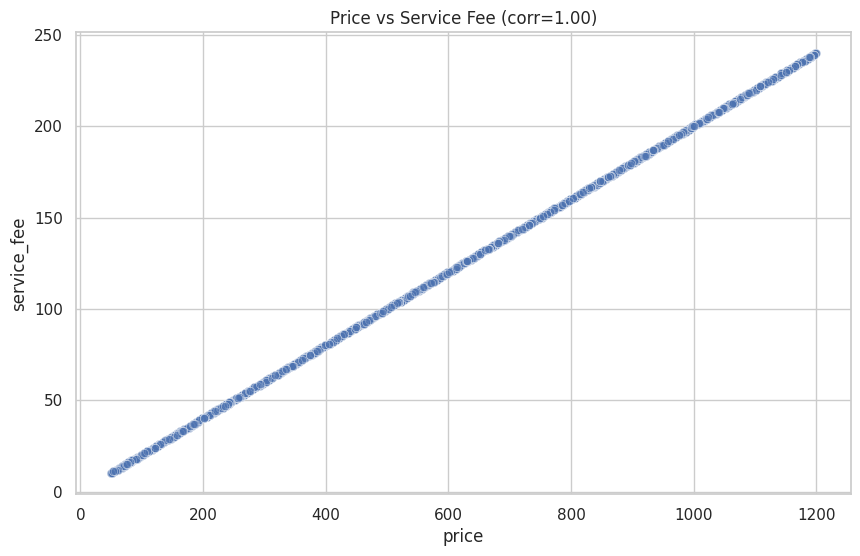

In [21]:
# 7️⃣ Correlation between price and service fee
if set(["price","service_fee"]).issubset(df.columns):
    corr_val = df[["price","service_fee"]].corr().iloc[0,1]
    print(f"Correlation between price and service fee: {corr_val:.3f}")

    sns.scatterplot(data=df.sample(min(3000, len(df)), random_state=42),
                    x="price", y="service_fee", alpha=0.5)
    plt.title(f"Price vs Service Fee (corr={corr_val:.2f})")
    plt.show()
else:
    print("Required columns not found.")


**(8) What is the average review rating by neighborhood and room type?**

In [22]:
# 8️⃣ Average review rating by neighborhood group and room type

if set(["neighbourhood_group", "room_type", "review_rate_number"]).issubset(df.columns):
    review_group = (
        df.groupby(["neighbourhood_group", "room_type"])["review_rate_number"]
          .mean()
          .reset_index()
    )
    print(review_group.head())

    fig = px.bar(
        review_group,
        x="neighbourhood_group",
        y="review_rate_number",
        color="room_type",
        barmode="group",
        title="Average Review Rating by Neighborhood and Room Type",
        labels={
            "neighbourhood_group": "Neighborhood Group",
            "review_rate_number": "Average Review Rating"
        }
    )
    fig.show()
else:
    print("Required columns not found.")


  neighbourhood_group        room_type  review_rate_number
0               Bronx  Entire home/apt            3.349457
1               Bronx     Private room            3.327343
2               Bronx      Shared room            3.264957
3            Brooklyn  Entire home/apt            3.250122
4            Brooklyn       Hotel room            3.750000


(9) **Arehosts with more listings more likely to maintain higher availability?**

Correlation between host listings count and availability: 0.160


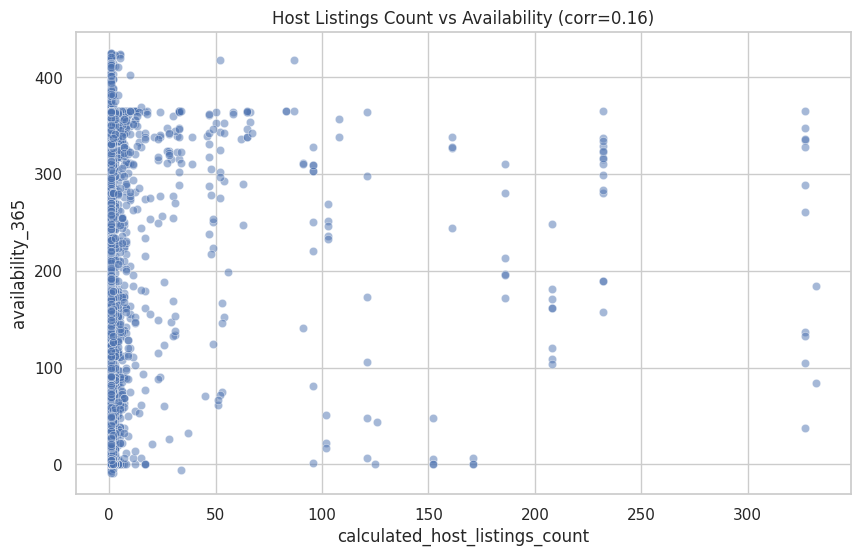

In [23]:
# 9️⃣ Relationship between host listings count and yearly availability
if set(["calculated_host_listings_count","availability_365"]).issubset(df.columns):
    corr_val = df["calculated_host_listings_count"].corr(df["availability_365"])
    print(f"Correlation between host listings count and availability: {corr_val:.3f}")

    sns.scatterplot(data=df.sample(min(3000, len(df)), random_state=42),
                    x="calculated_host_listings_count", y="availability_365", alpha=0.5)
    plt.title(f"Host Listings Count vs Availability (corr={corr_val:.2f})")
    plt.show()
else:
    print("Required columns not found.")
